# IR experimental code

In [1]:
import math
import os
from typing import List, Tuple

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from theia.utils import display, read_positions

In [2]:
def approxContour(contour, options):
    """
    fit contour to a simpler shape
    accuracy is based on EPSILON_MULTIPLY
    """
    epsilon = options['epsilon'] * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return approx

In [3]:
def calc_distance(p1, p2):
    """ return the distance between two points """
    return math.sqrt(((p2[0] - p1[0])**2) + ((p2[1] - p1[1])**2))


def get_contour_lengths(approx: List[List[List[int]]]) -> List[int]:
    """ 
    extract lengths from the co-ordinates 
    """
    # unnest and arrange into each corner co-ords
    # this could be done programmatically but not really worth it
    verticies = [
            [approx[0][0], approx[1][0]],
            [approx[1][0], approx[2][0]],
            [approx[2][0], approx[3][0]],
            [approx[3][0], approx[0][0]]
        ]
    lengths = list(map(lambda x: calc_distance(x[0], x[1]), verticies))
    return sorted(lengths)


def is_square(lengths, options) -> bool:
    """ check if the longest side is close in length to the shortest side """
    a = ((lengths[3] - lengths[0]) / lengths[3]) < options["square_ar"]
    b = ((lengths[3] - lengths[1]) / lengths[3]) < options["square_ar"]
    c = ((lengths[3] - lengths[1]) / lengths[3]) < options["square_ar"]
    return a & b & c

In [32]:
def filterContours(contours, options):
    """ 
    return only the contours that are squares
    """
    squareIndexes = []

    # filter contours
    for i, contour in enumerate(contours):  # for each of the found contours
        if cv2.contourArea(contour) > options["min_area"]:
            approx = approxContour(contour, options)
            if len(approx) in options["sides"]:
                area = cv2.contourArea(approx)
                hull = cv2.convexHull(approx)
                hull_area = cv2.contourArea(hull)
                solidity = float(area)/hull_area
                if solidity > options["min_solidity"]:
                    squareIndexes.append(i)
                #if is_square(get_contour_lengths(approx), options):
    
    return squareIndexes

In [5]:
def target_centre(contour: list) -> Tuple[int, int]:
    """ 
    given the square corners, return the centre of the square 
    """
    x = sum([item[0] for item in contour])/4
    y = sum([item[1] for item in contour])/4
    return int(x), int(y)

In [27]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def find_targets(image: np.ndarray, options) -> List[List[Tuple[int,int]]]:
    """ 
    return the centre position within the image
    """
    imgGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #cl1 = clahe.apply(imgGray)
    imgBlurred = cv2.GaussianBlur(imgGray, (options["ksize"], options["ksize"]), options["sigma"])
    img_thresh = cv2.adaptiveThreshold(
        imgBlurred,
        255,
        cv2.ADAPTIVE_THRESH_MEAN_C, 
        cv2.THRESH_BINARY,
        options["block_size"],
        options["c"]
    )

    #img_morph = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN, options["kernel"])
    
    if options["debug"]: 
        display(img_thresh)

    contours, hierarchy = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    squareIndexes = filterContours(contours, options)
    
    if options["debug"]:
        imgCopy = image
        # for cont in contours:
        #     cv2.drawContours(imgCopy, cont, -1, (0, 255, 0), 3)
        # display(imgCopy)
        img2 = image
        for index in squareIndexes:
            cv2.drawContours(img2, contours[index], -1, (0, 255, 0), 3)
        display(img2)

    # this for loop is mainly to check if there are multiple squares in the same image
    # otherwise there would not be a loop
    
    results = []
    for index in squareIndexes:
        target_contour = approxContour(contours[index], options)

        reshaped = target_contour.reshape(4,2)

        centre = target_centre(reshaped)

        results.append(
            centre
        )


    if len(results) == 0:
        pass

    return results

# sim_dataset testing

In [7]:
def centre_check(predicted, actual, tol=20) -> bool:
    """ True if the centre is as expected else False """
    x = math.isclose(predicted[0], actual[0], abs_tol=tol)
    y = math.isclose(predicted[1], actual[1], abs_tol=tol)
    return x & y

In [8]:
ref = read_positions("./dataset/target_positions")

In [25]:
image_number = 50
files = [f for f in os.listdir('./dataset/sim_dataset/')]
image = cv2.imread('./dataset/sim_dataset/' + files[image_number])
print(files[image_number])

options = {
    "block_size": 399,
    "c": -39,
    "ksize": 39,
    "sigma": 0,
    "epsilon": 0.1,
    "square_ar": 0.2,
    "min_area": 10000,
    "sides":[4],
    "debug":True,
    "kernel": np.ones((30,30),np.uint8)
}

predicted = find_targets(image, options)
print(predicted)
actual = ref[files[image_number]]
print(centre_check(predicted[0], actual))
print(len(predicted) == 1)

IMG_160729_071816_0092_RGB.JPG
[(977, 635)]
False
True


In [30]:
results = []
false_positives = []

for file in files:
    image = cv2.imread('./dataset/sim_dataset/' + file)
    result = find_targets(image, options, debug=False)
    try:
        result[0]
        for r in result:
            actual = ref[file]
            if centre_check(r, actual):
                results.append(1)
            else:
                results.append(0)
                false_positives.append(1)

    except:
        #result = find_targets(image, options, debug=True)
        results.append(0)

print(f"accuracy: {round(sum(results)/len(files) * 100, 2)} %")
print(f"false positives {round(sum(false_positives)/len(results) * 100, 2)} %")
print(f"no. images: {len(files)}")

accuracy: 89.02 %
false positives 1.15 %
no. images: 173


# Understanding parameter effects

In [ ]:
results = []
image = cv2.imread('./dataset/sim_dataset/' + files[image_number])

for block_size in range(29, 249, 20):
    print(block_size)
    for c in range(-100, 20, 20):
        for ksize in range(1, 9, 2):
            for sigma in [0]: #range(0, 10, 2):
                options = {
                    "block_size": block_size,
                    "c": c,
                    "ksize": ksize,
                    "sigma": sigma
                }
                result = find_targets(image, options, debug=False)
                try:
                    result[0]
                    if result[0][0] > 1080 and result[0][0] < 1100:
                        ans = 1
                    else:
                        ans = 0
                except:
                    ans = 0
                
                results.append((block_size, c, ksize, sigma, ans))

In [ ]:
df = pd.DataFrame(results)

,0,1,2,3,4
0,29,-100,1,0,0
1,29,-100,3,0,0
2,29,-100,5,0,0
3,29,-100,7,0,0
4,29,-80,1,0,0
...,...,...,...,...,...
331,289,-20,7,0,0
332,289,0,1,0,0
333,289,0,3,0,0
334,289,0,5,0,0


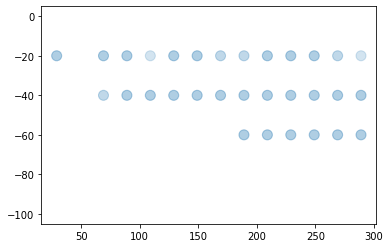

In [ ]:
plt.scatter(df[0], df[1], s=df[4]*100, alpha=0.1)

In [ ]:
df = df[df[4] == 1]

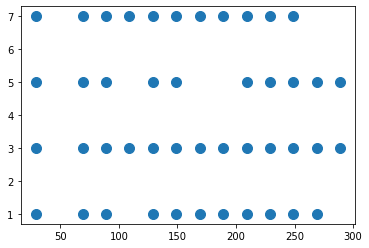

In [ ]:
df2 = df[df[1] == -20]
plt.scatter(df2[0], df2[2], s=100, alpha=1)

# Testing main IR functions

In [1]:
from theia import main
from theia import spec
import cv2
import os
from importlib import reload
reload(main)

loc = spec.LocationInfo()
image_number = 50
files = [f for f in os.listdir('./dataset/sim_dataset/')]
image = cv2.imread('./dataset/sim_dataset/' + files[image_number])
print(files[image_number])
base_dir = os.getcwd()

IMG_160729_071816_0092_RGB.JPG


In [2]:
ir = main.ImageRecognition(base_dir)
ir.image_recognition(image, loc)

2022-01-26 14:54:42,172, [INFO], main , processing image
2022-01-26 14:54:42,492, [INFO], main , ImageRecognitionResult(image_name='c:\\Users\\olive\\Documents\\GitHub\\uas-theia\\runtime\\26012022_14-54-42.240916.jpg', centre=(2310, 3193), position=(0.0, 0.0))


# Experimenting with perspective

In [18]:
ref = read_positions("./dataset/target_positions_transformed")

result = 0
files = [f for f in os.listdir('./dataset/transform_dataset/')]
for image_number in [99]: #range(len(files)):
    image = cv2.imread('./dataset/transform_dataset/' + files[image_number])
    print(files[image_number])

    options = {
        "block_size": 249,
        "c": -39,
        "ksize": 49,
        "sigma": 0,
        "epsilon": 0.02,
        "square_ar": 0.4,
        "min_area": 3000,
    }

    predicted = find_targets(image, options, debug=True)
    if len(predicted) >= 0:
        result+=1
    print(predicted)

print(result/len(files))
print(centre_check(predicted[0], (1316, 2532)))

900-900.jpg
[(1318, 2534), (3707, 288)]
0.01
True


In [33]:
options = {
    "block_size": 249,
    "c": -39,
    "ksize": 49,
    "sigma": 0,
    "epsilon": 0.02,
    "square_ar": 0.4,
    "min_area": 3000,
}
ref = read_positions("./dataset/target_positions_transformed", offset=0)
files = [f for f in os.listdir('./dataset/transform_dataset/')]
results = []
false_positives = []

for file in files:
    image = cv2.imread('./dataset/transform_dataset/' + file)
    result = find_targets(image, options, debug=False)
    try:
        result[0]
        for r in result:
            actual = ref[file]

            if centre_check(r, actual):
                results.append(1)
            else:
                results.append(0)
                false_positives.append(1)

    except Exception as e:
        results.append(0)

print(f"accuracy: {round(sum(results)/len(files) * 100, 2)} %")
print(f"false positives {round(sum(false_positives)/len(results) * 100, 2)} %")
print(f"no. images: {len(files)}")

accuracy: 80.35 %
false positives 13.55 %
no. images: 1557


# other

In [5]:
from theia import position_estimation
from theia.spec import LocationInfo
from theia.image_segmentation import find_targets
from theia.utils import display
import cv2
import os
import math
import geopy.distance


target_location = (51.292308, -0.484431)
directory = r"C:\Users\olive\University of Surrey\UAS2 - General\2 Avionics\4 Testing\Image Rec\10_04_22\squares"

image_number = 23
files = [f for f in os.listdir(directory)]
image = cv2.imread(directory + "//" + files[image_number])

name = files[image_number]
name = name.split(",")

start_height = 35

options = {
    "block_size": 399,
    "c": -39,
    "ksize": 39,
    "sigma": 0,
    "epsilon": 0.1,
    "square_ar": 0.2,
    "min_area": 1000,
    "sides":[4],
    "debug":False,
    "min_solidity":0.6
}



error_x = []
error_y = []
image_pitch = []
image_roll = []
image_height = []
image_heading = []
image_time = []
total_error=[]
dist_error = []

for file in files:
    image = cv2.imread(directory + "//" + file)
    predicted = find_targets(image, options)
    name = file.split(",")
    try:
        l = LocationInfo(lat=float(name[2]), lon=float(name[1]), alt=float(name[0])-start_height,heading=float(name[3]), pitch=float(name[5]), roll=float(name[4]))
        predicted_location = position_estimation.triangulate(predicted[0], l)

        err = math.sqrt((predicted_location[0]-target_location[0])**2+(predicted_location[1]-target_location[1])**2)
        if err > 0.004:
            pass
        else:
            image_pitch.append(l.pitch)
            image_roll.append(l.roll)
            image_height.append(l.alt)
            image_heading.append(l.heading)
            image_time.append(name[6])
            error_x.append(predicted_location[0]-target_location[0])
            error_y.append(predicted_location[1]-target_location[1])
            dist_error.append(geopy.distance.distance(target_location, predicted_location).m)
            
            total_error.append(math.sqrt((predicted_location[0]-target_location[0])**2+(predicted_location[1]-target_location[1])**2))
            print(geopy.distance.distance(target_location, predicted_location).m)

    except Exception as e:
        print(e)




115.38291880482305
102.52991461166843
147.5838761198511
265.00670168849956
300.54395459478707
list index out of range
22.163807559407342
21.714608865188207
28.259827304570535
38.97508553284461
55.535232088467055
59.960593916925255
59.24210286775423
66.29214498127531
list index out of range
list index out of range
list index out of range
list index out of range
82.67550847120134
102.64033747874151
91.51864674605434
116.40961161276228
list index out of range
list index out of range
55.079004012834524
35.30062150041211
82.51140695987236
216.30410777458147


0.0006861481553920882
-0.0004603047123263421


Text(0, 0.5, 'error (m)')

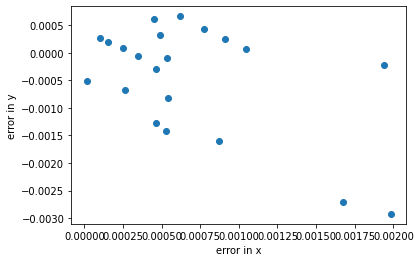

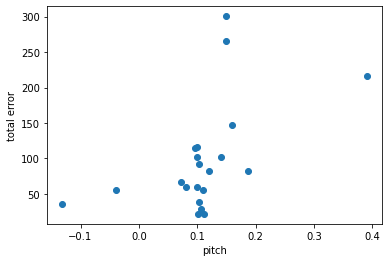

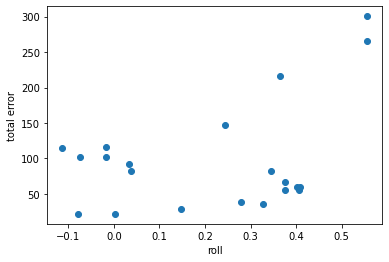

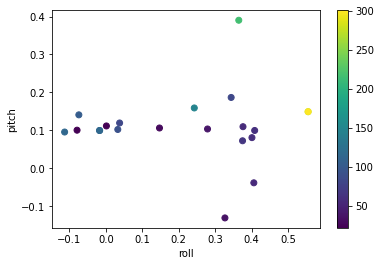

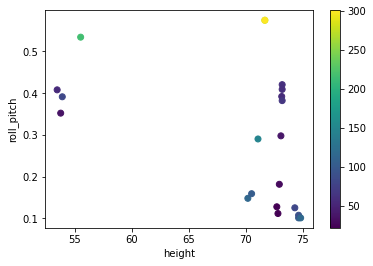

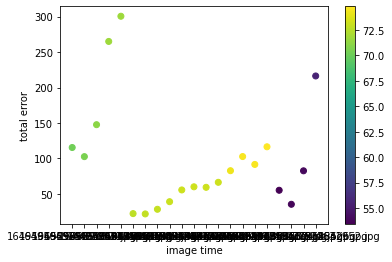

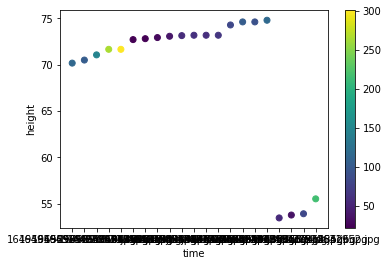

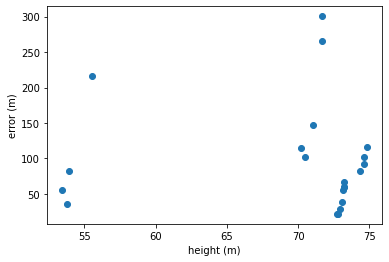

In [6]:
import matplotlib.pyplot as plt
import math
import numpy as np

print(sum(error_x)/len(error_x))
print(sum(error_y)/len(error_y))

total_error=[]
for i in range(len(error_x)):
    total_error.append(math.sqrt(error_x[i]**2+error_y[i]**2))

plt.figure(0)
plt.scatter(error_x,error_y)
plt.xlabel("error in x")
plt.ylabel("error in y")

plt.figure(1)
plt.scatter(image_pitch,dist_error)
plt.xlabel("pitch")
plt.ylabel("total error")

plt.figure(2)
plt.scatter(image_roll,dist_error)
plt.xlabel("roll")
plt.ylabel("total error")


plt.figure(3)
plt.scatter(image_roll, image_pitch, c=dist_error, cmap='viridis')
plt.colorbar()
plt.xlabel("roll")
plt.ylabel("pitch")

roll_pitch=[]
for i in range(len(error_x)):
    roll_pitch.append(math.sqrt(image_pitch[i]**2+image_roll[i]**2))

plt.figure(4)
plt.scatter(image_height,roll_pitch,c=dist_error, cmap='viridis')
plt.colorbar()
plt.xlabel("height")
plt.ylabel("roll_pitch")

plt.figure(5)
plt.scatter(image_time,dist_error,c=image_height, cmap='viridis')
plt.colorbar()
plt.xlabel("image time")
plt.ylabel("total error")

plt.figure(6)
plt.scatter(image_time,image_height,c=dist_error, cmap='viridis')
plt.colorbar()
plt.xlabel("time")
plt.ylabel("height")

plt.figure(7)
plt.scatter(image_height, dist_error)
plt.xlabel("height (m)")
plt.ylabel("error (m)")


C:\Users\olive\AppData\Local\Temp\ipykernel_40092\2103206861.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


<Figure size 432x288 with 0 Axes>

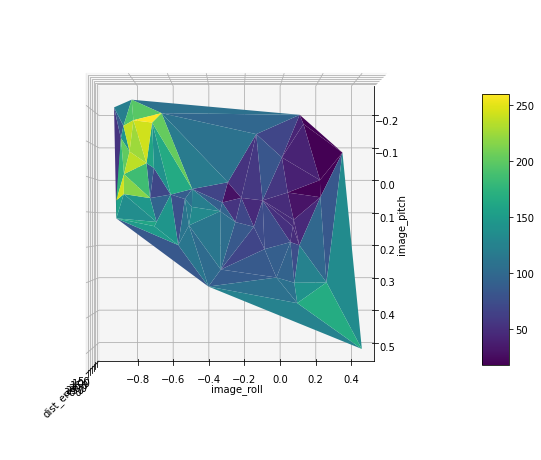

0    -0.172233
1    -0.199654
2    -0.153296
3     0.189444
4    -0.161504
5     0.199023
6     0.065537
7    -0.047367
8     0.502945
9     0.030024
10    0.311248
11    0.096410
12    0.294466
13   -0.066314
14    0.063094
15    0.272909
16   -0.135771
17    0.304700
18    0.371384
19   -0.192256
20    0.197962
21    0.128402
22   -0.155600
23   -0.006430
24    0.083465
25    0.059079
26    0.044995
27    0.138680
28    0.140828
29    0.121705
30    0.322832
31    0.141720
32    0.142945
33    0.128640
34    0.210415
35   -0.074292
36   -0.236537
37   -0.217858
38   -0.129143
39   -0.035791
40    0.007827
41    0.117465
42    0.068603
43    0.056803
44    0.047161
45    0.052510
46    0.054244
47    0.037956
48    0.000018
49   -0.084658
Name: x, dtype: float64
0     0.129108
1     0.107176
2    -0.680518
3     0.052480
4    -0.780167
5     0.102589
6    -0.887848
7    -0.734388
8     0.428114
9    -0.485822
10    0.071909
11   -0.333281
12   -0.027446
13    0.004475
14   -0.101021
1

In [3]:

plt.figure(8)
import pandas as pd
import seaborn as sns
df = pd.DataFrame.from_dict(np.array([image_pitch,image_roll,dist_error]).T)
df.columns = ['x','y','z']
df['z'] = pd.to_numeric(df['z'])
pivotted= df.pivot('y','x','z')

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_xlabel('image_pitch')
ax.set_ylabel('image_roll')
ax.set_zlabel('dist_error')
#ax.plot_wireframe(cParams, gammas, avg_errors_array)
#ax.plot3D(cParams, gammas, avg_errors_array)
#ax.scatter3D(cParams, gammas, avg_errors_array, zdir='z',cmap='viridis')

surf = ax.plot_trisurf(df.x, df.y, df.z, cmap='viridis', linewidth=0.1)
ax.view_init(azim=0, elev=90)
fig.colorbar(surf, shrink=0.5, aspect=10)    
plt.show()

print(df.x)
print(df.y)
print(df.z)
  

tried morphology, reduces noise but increases processing time by ~5%. doesn't seem to affect accuracy.
https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html

tried CLACHE - no noticeable accuracy increase

tried making C more negative - reduces noise and chance of identifying target

In [4]:
directory = r"C:\Users\olive\University of Surrey\UAS2 - General\2 Avionics\4 Testing\Image Rec\10_04_22\squares"
files = [f for f in os.listdir(directory)]


options = {
    "block_size": 399,
    "c": -39,
    "ksize": 39,
    "sigma": 0,
    "epsilon": 0.1,
    "square_ar": 0.2,
    "min_area": 1000,
    "sides":[4],
    "min_solidity": 0.6,
    "debug":True
}

results = 0
false_positives = []

for file in files:
    image = cv2.imread(directory + "//" + file)
    result = find_targets(image, options)
    try:
        result[0]
        results+=1
    except KeyboardInterrupt:
        raise Exception()
    except Exception:
        #find_targets(image, options)
        pass

print(results/len(files))
print(results)
print(len(files))


0.7666666666666667
23
30


In [ ]:
directory = r"C:\Users\olive\University of Surrey\UAS2 - General\2 Avionics\4 Testing\Image Rec\03_04_22\square"
image_number = 23
files = [f for f in os.listdir(directory)]
image = cv2.imread(directory + "//" + files[image_number])

options = {
    "block_size": 399,
    "c": -39,
    "ksize": 39,
    "sigma": 0,
    "epsilon": 0.1,
    "square_ar": 0.2,
    "min_area": 1000,
    "sides":[4],
    "debug":False
}

imgGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
display(imgGray)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(imgGray)
display(cl1)
imgBlurred = cv2.GaussianBlur(cl1, (59,59),0)
# laplacian = cv2.Laplacian(cv2.bitwise_not(imgBlurred),cv2.CV_64F)
# display(laplacian)
img_thresh = cv2.adaptiveThreshold(
    imgBlurred,
    255,
    cv2.ADAPTIVE_THRESH_MEAN_C, 
    cv2.THRESH_BINARY,
    399,
    -69
)
display(img_thresh)

contours, hierarchy = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
squareIndexes = filterContours(contours, options)

for index in squareIndexes:
    cv2.drawContours(image, contours[index], -1, (0, 255, 0), 3)
display(image)